#  Unsupervised learning addition model

Author: S. Menary [sbmenary@gmail.com]

Date: 5/4/2023  (last update: 9/4/2023)

Overview: Train a `sequence -> sequence` model where the input sequence is a text representation of a simple sum $A \pm B$ for integers $A,B\in\mathbb{Z}\left([-N,~N]\right)$ for some maximum-amplitude $N$, and the output is a text representation of the answer. Since the output is a numerical value, the loss function is a sparse categorical entropy

---

## 1. Set up program

###  Import

All imports go here at the top of the notebook

In [1]:
##=========================##
##   All imports go here   ##
##=========================##

##  Import entire python stdlib packages
import logging, os, sys

##  Import entire pypi packages
import tensorflow as tf

##  Add directory above this to system path to expose mathsformer package location
sys.path.append("/".join(os.getcwd().split("/")[:-1]))

##  Import individual modules/objects from local packages
from mathsformer import config, data, transformers, utils
from mathsformer import selfsupervised_learning_addition_model_backend as backend


### Configuation

Set global configuration variables

In [2]:
##==============================##
##   Set custom config values   ##
##==============================##

custom_config = {
    "global" : {
        "base_seed"        : -1,
        "working_dir"      : "SSL_addition_notebook_[problem_tag]_[model_tag]_[date]",
        "problem_tag"      : "int99",
        "model_tag"        : "baseline",
        "log_lvl_iostream" : logging.INFO,
        "log_lvl_fstream"  : logging.DEBUG,
    },
    "data" : {
        "max_int"           : 999,
        "characters"        : ['M', 'B', 'E', 'N', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '+', '-'],
        "mask_char"         : 'M',
        "seq_start_char"    : 'B',
        "seq_end_char"      : 'E',
        "negative_char"     : 'N',
        "dtype"             : "int32",
        "test_split_idx"    : 0.02,
        "val_split_idx"     : 0.04,
    },
    "model" : {
        "load_pretrained_model" : None,
        "name"                  : "mathsformer_LLM",
        "dtype"                 : "float32",
        "dropout"               : 0.1,
        "learning_rate"         : 5e-4,
        "jit_compile"           : False,
        "positional_encoding" : {
            "num_freqs"         : 16,
            "min_period"        : 4,
            "max_period"        : 200,
            "learnable"         : True,
        },
        "ndim_embedding"        : 32,
        "comb_type"             : 'average',
        "pre_encoder"           : {
            "num_layers"        : -1,
            "ndim"              : 128,
            "skip_connect"      : True,
        },
        "pre_decoder" : {
            "num_layers"        : -1,
            "ndim"              : 128,
            "skip_connect"      : True,
        },
        "encoder" : {
            "num_blocks"        : 5,
            "num_heads"         : 8,
            "ndim"              : 32,
            "ndim_att_hidden"   : 32,
            "ndim_ff_hidden"    : 128,
            "skip_connect"      : True,
        },
        "decoder" : {
            "num_blocks"        : 5,
            "num_heads"         : 8,
            "ndim"              : 32,
            "ndim_att_hidden"   : 32,
            "ndim_ff_hidden"    : 128,
            "skip_connect"      : True,
        },
        "post_decoder" : {
            "num_layers"        : 3,
            "ndim"              : 128,
        },
    },
    "training" : {
        "train"      : True,
        "max_epochs" : 1000,
        "batch_size" : 32,
        "log_after_epoch" : {
            "do"          : True,
            "log_lvl"     : logging.DEBUG,
        },
        "early_stopping" : {
            "do"                   : True,
            "patience"             : 6,
            "monitor"              : "loss",
            "mode"                 : "min",
            "restore_best_weights" : True,
        },
        "model_checkpoint" : {
            "do"       : True,
            "filename" : "model_checkpoint_epoch{epoch}_val_loss_{val_loss:.5}.h5",
        },
        "layer_activation_record" : {
            "do"               : False,
            "batch_frequency"  : 2000,
            "max_datapoints"   : 32,
        },
        "layer_weights_record" : {
            "do"               : True,
            "batch_frequency"  : 5000,
            "recursive"        : True,
        },
        "loss_record" : {
            "do"               : True,
            "batch_frequency"  : 2000,
            "max_datapoints"   : 256,
            "num_bootstrap"    : 20,
            "plot_frequency"   : 20000, 
            "plot_after_epoch" : True, 
        },
        "adaptive_learning_rate" : {
            "do"                 : True,
            "decay_factor"       : 0.3,
            "monitor"            : "loss",
            "mode"               : "min",
            "patience"           : 1,
            "log_lvl"            : logging.DEBUG,
        },
        "print_tables_during_training" : {
            "do"        : True,
            "num_print" : 7,
        },
    },
    "evaluate" : {
        "num_print"            : 20,
        "save_model"           : True,
        "plot_weights"         : False,
        "plot_training_curves" : True,
    },
}


###  Validate config

Look for some obvious confguration errors. WARNING: This is not an exhaustive search and can't be replied upon to catch all misconfigurations!

In [3]:
##===================================##
##   Load and validate full config   ##
##===================================##

##  Create config object containing default values
cfg = config.Config(backend.DEFAULT_CONFIG)

##  Override with custom values
cfg.load_dict(custom_config)

##  Validate config
backend.validate_config(cfg)

##  Print success
print(utils.fancy_message(f"Config created"))

##  For convenience, split configs for different sections
cfg_global   = cfg["global"  ]
cfg_data     = cfg["data"    ]
cfg_model    = cfg["model"   ]
cfg_training = cfg["training"]
cfg_evaluate = cfg["evaluate"]


===   Config created   ===


##  2. Set up environment

- Create working directory
- Create logger
- Log package versions for reproducibility
- Log config values for reproducibility
- Set random seeds for reproducibility


In [4]:
##==============================##
##   Create working directory   ##
##==============================##

##  Report success
working_dir, logger, base_seed, np_seed, tf_seed = utils.initialise_program(
    "unsupervised_learning_addition_model_generator (notebook)", 
    working_dir       = cfg_global["working_dir"], 
    cfg               = cfg,
    base_seed         = cfg_global["base_seed"],
    log_lvl_iostream  = cfg_global["log_lvl_iostream"],
    log_lvl_fstream   = cfg_global["log_lvl_fstream" ],
)


===   Working directory created at SSL_addition_notebook_int99_baseline_2023_04_25_v14   ===
   INFO initialise_logging: Begin logging on 2023-04-25 at 16:07:05
   INFO initialise_program: Program description: unsupervised_learning_addition_model_generator (notebook)
   INFO initialise_program: Working directory: SSL_addition_notebook_int99_baseline_2023_04_25_v14
   INFO log_versions: ------------------------------------------------------+----------------------------------------------------------------------------------
   INFO log_versions:                                              PACKAGE  |  VERSION
   INFO log_versions: ------------------------------------------------------+----------------------------------------------------------------------------------
   INFO log_versions:                                               Python  |  3.10.8 | packaged by conda-forge | (main, Nov 22 2022, 08:25:29) [Clang 14.0.6 ]
   INFO log_versions:                                             

   INFO log_versions:                                       prompt_toolkit  |  3.0.36
   INFO log_versions:                                               psutil  |  5.9.4
   INFO log_versions:                                           ptyprocess  |  0.7.0
   INFO log_versions:                                            pure_eval  |  0.2.2
   INFO log_versions:                                    pure_eval.version  |  0.2.2
   INFO log_versions:                                               pydevd  |  2.9.1
   INFO log_versions:                                             pygments  |  2.13.0
   INFO log_versions:                                            pyparsing  |  3.0.9
   INFO log_versions:                                                   re  |  2.2.1
   INFO log_versions:                                             requests  |  2.28.1
   INFO log_versions:                                 requests.__version__  |  2.28.1
   INFO log_versions:                                        

   INFO initialise_program: Registered config value data > test_data > gen_reproducible: True
   INFO initialise_program: Registered config value data > characters: ['M', 'B', 'E', 'N', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '+', '-']
   INFO initialise_program: Registered config value data > mask_char: M
   INFO initialise_program: Registered config value data > seq_start_char: B
   INFO initialise_program: Registered config value data > seq_end_char: E
   INFO initialise_program: Registered config value data > negative_char: N
   INFO initialise_program: Registered config value data > dtype: int32
   INFO initialise_program: Registered config value data > max_int: 99
   INFO initialise_program: Registered config value data > test_split_idx: 0.05
   INFO initialise_program: Registered config value data > val_split_idx: 0.1
   INFO initialise_program: Registered config value model > load_pretrained_model: None
   INFO initialise_program: Registered config value model > name:

##  3. Create training data

###  Create tokeniser

Tokeniser object handles the transformation from strings to tensors and back again

In [5]:
##======================##
##   Create tokeniser   ##
##======================##

token_transform = data.TokenTransform.from_dictionary(cfg_data)
token_transform.summary(print_fn=logger.info)


   INFO summary: TokenTransform of dtype int32 with 16 characters: ['M', 'B', 'E', 'N', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '+', '-']
   INFO summary: Special characters are seq_start_char (B), seq_end_char (E), mask_char (M)
   INFO summary: Tokeniser dictionary is {'M': 0, 'B': 1, 'E': 2, 'N': 3, '0': 4, '1': 5, '2': 6, '3': 7, '4': 8, '5': 9, '6': 10, '7': 11, '8': 12, '9': 13, '+': 14, '-': 15}
   INFO summary: Detokeniser dictionary is {0: 'M', 1: 'B', 2: 'E', 3: 'N', 4: '0', 5: '1', 6: '2', 7: '3', 8: '4', 9: '5', 10: '6', 11: '7', 12: '8', 13: '9', 14: '+', 15: '-'}


##  3. Create training data

###  Generate string-string pairs

###   Process strings into fixed-length tokenised dataset with position indices

In [6]:
##===================================##
##   Create dataset of raw strings   ##
##===================================##

data_X, data_Y_in, data_Y_out = backend.create_tensor_dataset(
    token_transform = token_transform, 
    max_int         = cfg_data.get("max_int"),
    negative_char   = cfg_data.get("negative_char"),
    include_neg     = True, 
    shuffle         = True)


   INFO create_tensor_dataset: Creating data tensors with max_int=99, negative_char=N, include_neg=True, shuffle=True
   INFO create_tensor_dataset: Created list of strings with length 79,202 in 0.1s
   INFO create_tensor_dataset: Strings converted to tensors with shape [(79202, 9), (79202, 5)], (79202, 5) in 0.3s


In [7]:
##==================================##
##   Perform train/val/test split   ##
##==================================##

split_idx1, split_idx2 = cfg_data.get("test_split_idx", 0.1), cfg_data.get("val_split_idx" , 0.3)

test_X    , val_X    , train_X     = data.train_val_test_split(data_X    , split_idx1, split_idx2)
test_Y_in , val_Y_in , train_Y_in  = data.train_val_test_split(data_Y_in , split_idx1, split_idx2)
test_Y_out, val_Y_out, train_Y_out = data.train_val_test_split(data_Y_out, split_idx1, split_idx2)

logger.info(f"  Training data with shape {train_X.shape}, {train_Y_in.shape} and labels {train_Y_out.shape}")
logger.info(f"Validation data with shape {  val_X.shape}, {  val_Y_in.shape} and labels {  val_Y_out.shape}")
logger.info(f"      Test data with shape { test_X.shape}, { test_Y_in.shape} and labels { test_Y_out.shape}")

del data_X, data_Y_in, data_Y_out


   INFO <module>:   Training data with shape (71282, 9), (71282, 5) and labels (71282, 5)
   INFO <module>: Validation data with shape (3960, 9), (3960, 5) and labels (3960, 5)
   INFO <module>:       Test data with shape (3960, 9), (3960, 5) and labels (3960, 5)


##  4.  Create model

In [8]:
##===================================================##
##   Load or create self-supervised learning model   ##
##===================================================##

##  Get filename for load model
fname = cfg_model.get("load_pretrained_model", None)

##  Load model if fname is not None, otherwise create from scratch
if fname is not None :
    logger.info   (f"Loading model from: {fname}")
    logger.warning("Loading a pretrained model will disregard model config!")
    model = backend.load_text_to_text_model(fname)
else :
    logger.info(f"Creating new text-to-text model")
    model = backend.create_text_to_text_model_from_config(cfg_model, token_transform)

##  Create hack to catch model summary
model_summary = []
model.summary(print_fn = lambda s : model_summary.append(s))

##  Print model summary
logger.info("Model created with summary:")
for s in model_summary : logger.info(s)


   INFO <module>: Creating new text-to-text model
   INFO <module>: Model created with summary:
   INFO <module>: Model: "mathsformer_LLM"
   INFO <module>: __________________________________________________________________________________________________
   INFO <module>:  Layer (type)                   Output Shape         Param #     Connected to                     
   INFO <module>: ==================================================================================================
   INFO <module>:  mathsformer_LLM_encoder_input_  [(None, None)]      0           []                               
   INFO <module>:  layer (InputLayer)                                                                               
   INFO <module>:                                                                                                   
   INFO <module>:  mathsformer_LLM_encoder_enumer  (1, None)           0           ['mathsformer_LLM_encoder_input_l
   INFO <module>:  ate (Enumerate)        

   INFO <module>: __________________________________________________________________________________________________


In [9]:
##==============================================================##
##   Create transformer wrapper for model and token_transform   ##
##==============================================================##

transformer = transformers.Transformer_Text_to_Text(model, token_transform)


In [10]:
##=========================================##
##   Test transformer on data generators   ##
##=========================================##

backend.test_transformer(transformer, 
                         ((train_X, train_Y_in), train_Y_out), 
                         ((val_X  , val_Y_in  ), val_Y_out  ), 
                         ((test_X , test_Y_in ), test_Y_out ), 
                         num_print=10, max_tokens=20, max_col_length=20,
                         negative_char=cfg_data.get("negative_char"))


   INFO test_transformer: Running text --> text mathsformer inference on some training data:
   INFO print_predictions_table: ------------------------------------------------------------------------------
   INFO print_predictions_table:         INPUT         TRUE   PRED(MASK)    PRED(GEN)      CORRECT     RESIDUAL
   INFO print_predictions_table: ------------------------------------------------------------------------------
   INFO print_predictions_table:         72+11           83        EE3B2                                   ?   
   INFO print_predictions_table:          41+8           49        E63B2                                   ?   
   INFO print_predictions_table:        N27-64          N91        E63B2                                   ?   
   INFO print_predictions_table:        N17-90         N107        E63B2                                   ?   
   INFO print_predictions_table:       N63+N43         N106        E63B2                                   ?   
   INFO pri

##  5.  Train model

In [11]:
##===================================##
##   Create callbacks for training   ##
##===================================##

callbacks = backend.get_callbacks(cfg_training, 
                                  working_dir, 
                                  transformer   = transformer, 
                                  train_gen     = ((train_X, train_Y_in), train_Y_out),
                                  val_gen       = ((val_X  , val_Y_in  ), val_Y_out  ),
                                  negative_char = cfg_data.get("negative_char")
                                 )


   INFO get_callbacks: Registered training callback: LoggerCallback with loglvl=10
   INFO get_callbacks: Registered training callback: EarlyStopping with monitor=loss, mode=min, patience=6, restore_best_weights=True
   INFO get_callbacks: Registeried training callback: AdaptiveLearningRate with decay_factor=0.3, patience=1, monitor=loss, mode=min, log_lvl=10
   INFO get_callbacks: Registeried training callback: ModelCheckpoint with filepath=SSL_addition_notebook_int99_baseline_2023_04_25_v14/model_checkpoint_epoch{epoch}_val_loss_{val_loss:.5}.h5
   INFO get_callbacks: Registered training callback: LayerWeightsRecord with batch_frequency=2000, recursive=True
   INFO get_callbacks: Registered training callback: LambdaCallback for test_transformer with num_print=7
   INFO get_callbacks: Registered training callback: MetricRecord with batch_frequency=1000, max_datapoints=256, num_bootstrap=20, plot_frequency=-1, plot_after_epoch=True, log_lvl=log_lvl
   INFO get_callbacks: Registered tra

   INFO <module>: Begin model training with max_epochs=1, batch_size=32


2023-04-25 16:07:08.984441: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


2228/2228 [==============================] - ETA: 0s - loss: 1.2458 - masked_categorical_accuracy: 0.5519

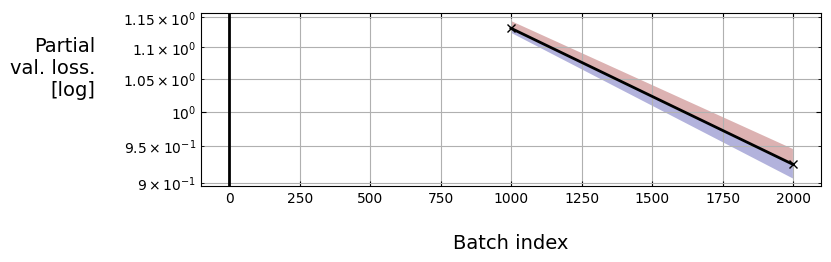

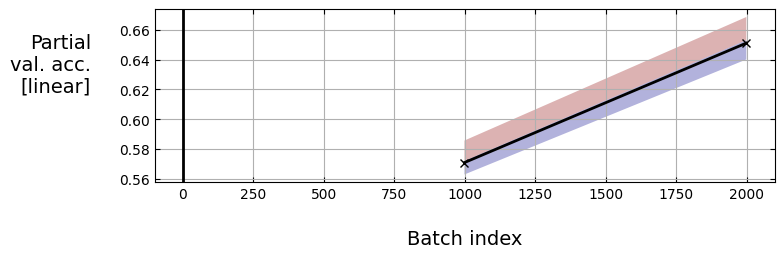

2228/2228 [==============================] - 104s 45ms/step - loss: 1.2458 - masked_categorical_accuracy: 0.5519 - val_loss: 0.9104 - val_masked_categorical_accuracy: 0.6497


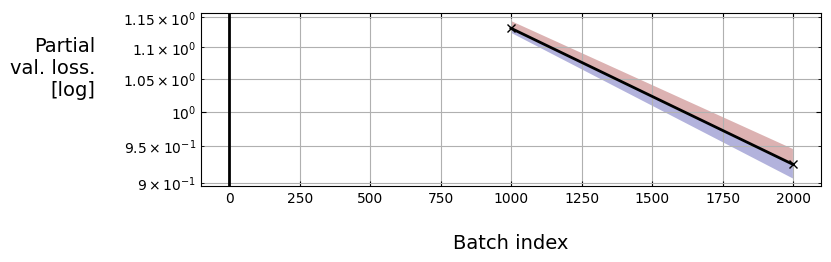

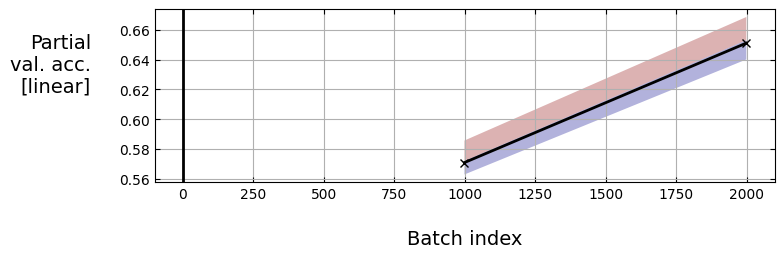

In [12]:
##=================##
##   Train model   ##
##=================##


##  Fit the model if configured
if cfg_training.get("train",True) :
    max_epochs = cfg_training["max_epochs"]
    batch_size = cfg_training["batch_size"]
    
    logger.info(f"Begin model training with max_epochs={max_epochs}, batch_size={batch_size}")
    model.fit([train_X, train_Y_in], 
              train_Y_out,
              epochs          = max_epochs,
              batch_size      = batch_size,
              validation_data = ([val_X, val_Y_in], val_Y_out),
              callbacks       = callbacks
             )
else :
    logger.warning("Skipping model training following global config instructions")


In [13]:
##================##
##   Save model   ##
##================##

do_save = cfg_evaluate.get("save_model", True)

if do_save :
    save_fname = f"{working_dir}/final_model.h5"
    model.save(save_fname)
    logger.info(f"Model saved to file {save_fname}")
else :
    logger.warning("Not saving model because no training was done")


   INFO <module>: Model saved to file SSL_addition_notebook_int99_baseline_2023_04_25_v14/final_model.h5


## 6.  Evaluate model

In [14]:
  
##  Find out how many datapoints to print predictions for 
num_print = cfg_evaluate.get("num_print", 20)

##  Print tables
backend.test_transformer(transformer, 
                         ([train_X, train_Y_in], train_Y_out), 
                         ([val_X, val_Y_in], val_Y_out), 
                         ([test_X, test_Y_in], test_Y_out), 
                         num_print=num_print,
                         negative_char=cfg_data.get("negative_char"))


   INFO test_transformer: Running text --> text mathsformer inference on some training data:
   INFO print_predictions_table: ------------------------------------------------------------------------------
   INFO print_predictions_table:         INPUT         TRUE   PRED(MASK)    PRED(GEN)      CORRECT     RESIDUAL
   INFO print_predictions_table: ------------------------------------------------------------------------------
   INFO print_predictions_table:         72+11           83         87EE           87                         4
   INFO print_predictions_table:          41+8           49         57EE           57                         8
   INFO print_predictions_table:        N27-64          N91         N87E          N87                         4
   INFO print_predictions_table:        N17-90         N107         N107         N107          X              0
   INFO print_predictions_table:       N63+N43         N106         N907          N97                         9
   INFO pri

##  7. Additional visualisations

In [15]:
##=============================================##
##   Visualise layer weights during training   ##
##=============================================##

if cfg_evaluate["plot_weights"] :
    
    logger.info("Plotting weights")
    backend.plot_weights(callbacks, show=True, close=True, savefig=f"{working_dir}/layer_weights.pdf")
    

   INFO <module>: Plotting training curves


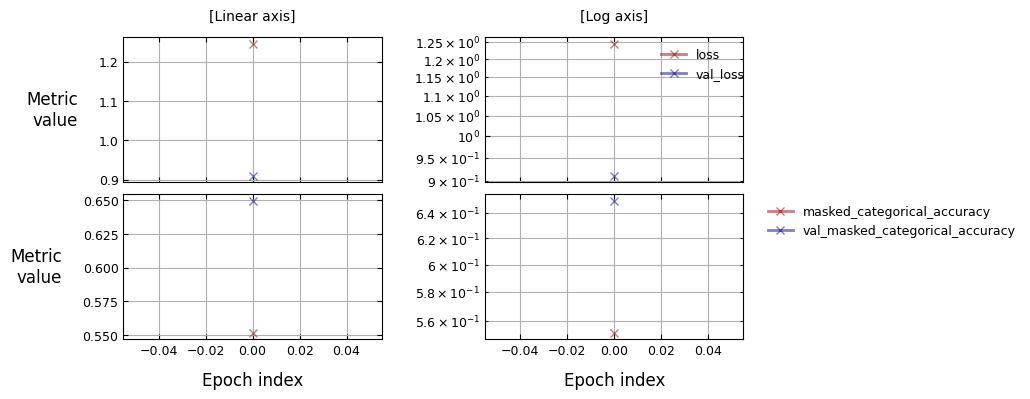

In [16]:

if cfg_evaluate["plot_training_curves"] :
    
    if not hasattr(model, "history") :
        logger.error("Cannot print training curves because no model history exists - perhaps you skipped training?")
    else :
        logger.info("Plotting training curves")
        backend.plot_training_curves(model.history.history, show=True, close=True, savefig=f"{working_dir}/training_curves.pdf")
    